# ROP Detection Project - Comprehensive Testing Notebook

This notebook tests each aspect of the ROP (Retinopathy of Prematurity) Detection project:
1. **Data Loading & Exploration**
2. **Preprocessing Pipeline Visualization** (including CLAHE)
3. **Model Architecture**
4. **Training & Validation**
5. **Performance Plots & Analysis**

## 1. Setup & Imports

In [1]:
import sys
from pathlib import Path

# Set project root
PROJECT_ROOT = Path(r"c:\Users\HP\Desktop\ROPDetectionAIML")
sys.path.insert(0, str(PROJECT_ROOT))

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import seaborn as sns

# Project imports
from src.data.dataset import ROPDataset
from src.data.transforms import CLAHETransform, get_transforms
from src.models.resnet import ResNet18ROP

# Settings
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.5.1+cpu


## 2. Data Exploration

In [2]:
# Load the CSV splits
train_csv = PROJECT_ROOT / "data" / "splits" / "train.csv"
val_csv = PROJECT_ROOT / "data" / "splits" / "val.csv"
test_csv = PROJECT_ROOT / "data" / "splits" / "test.csv"

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

print("Dataset Splits Summary:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTotal samples: {len(train_df) + len(val_df) + len(test_df)}")

# Display sample data
print("\nSample from training data:")
train_df.head()

Dataset Splits Summary:
Training samples: 398
Validation samples: 86
Test samples: 86

Total samples: 570

Sample from training data:


Source  ROP Label
0  C:\Users\HP\Desktop\ROPDetectionAIML\data\imag...          0
1  C:\Users\HP\Desktop\ROPDetectionAIML\data\imag...          0
2  C:\Users\HP\Desktop\ROPDetectionAIML\data\imag...          1
3  C:\Users\HP\Desktop\ROPDetectionAIML\data\imag...          0
4  C:\Users\HP\Desktop\ROPDetectionAIML\data\imag...          0

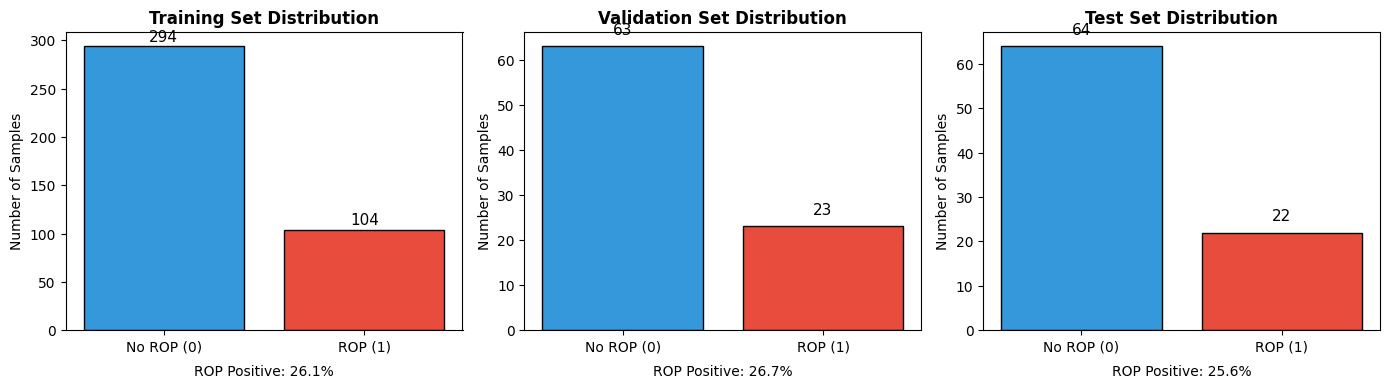


Class Imbalance Ratios:
Training: neg/pos ratio = 2.83
Validation: neg/pos ratio = 2.74
Test: neg/pos ratio = 2.91


In [3]:
# Class distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

datasets = [('Training', train_df), ('Validation', val_df), ('Test', test_df)]

for ax, (name, df) in zip(axes, datasets):
    counts = df['ROP Label'].value_counts().sort_index()
    colors = ['#3498db', '#e74c3c']
    bars = ax.bar(['No ROP (0)', 'ROP (1)'], counts.values, color=colors, edgecolor='black')
    ax.set_title(f'{name} Set Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Samples')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                str(count), ha='center', va='bottom', fontsize=11)
    
    # Add percentage
    total = counts.sum()
    ax.text(0.5, -0.15, f'ROP Positive: {counts.get(1,0)/total*100:.1f}%', 
            transform=ax.transAxes, ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'analysis' / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClass Imbalance Ratios:")
for name, df in datasets:
    n_pos = (df['ROP Label'] == 1).sum()
    n_neg = (df['ROP Label'] == 0).sum()
    print(f"{name}: neg/pos ratio = {n_neg/n_pos:.2f}")

## 3. Preprocessing Pipeline Visualization

Let's visualize each step of the preprocessing pipeline:
1. **Original Image** - Raw retinal fundus image
2. **Resized Image** - Resized to 224x224
3. **Green Channel Extraction** - Green channel has best vessel contrast
4. **CLAHE Applied** - Contrast Limited Adaptive Histogram Equalization
5. **Final Preprocessed** - After normalization

In [4]:
# Select sample images (one ROP positive, one negative)
rop_positive = train_df[train_df['ROP Label'] == 1].iloc[0]['Source']
rop_negative = train_df[train_df['ROP Label'] == 0].iloc[0]['Source']

sample_images = [
    (rop_negative, 'No ROP (Normal)'),
    (rop_positive, 'ROP Positive')
]

print("Sample images selected:")
for path, label in sample_images:
    print(f"  {label}: {Path(path).name}")

Sample images selected:
  No ROP (Normal): 5.jpg
  ROP Positive: 10.jpg


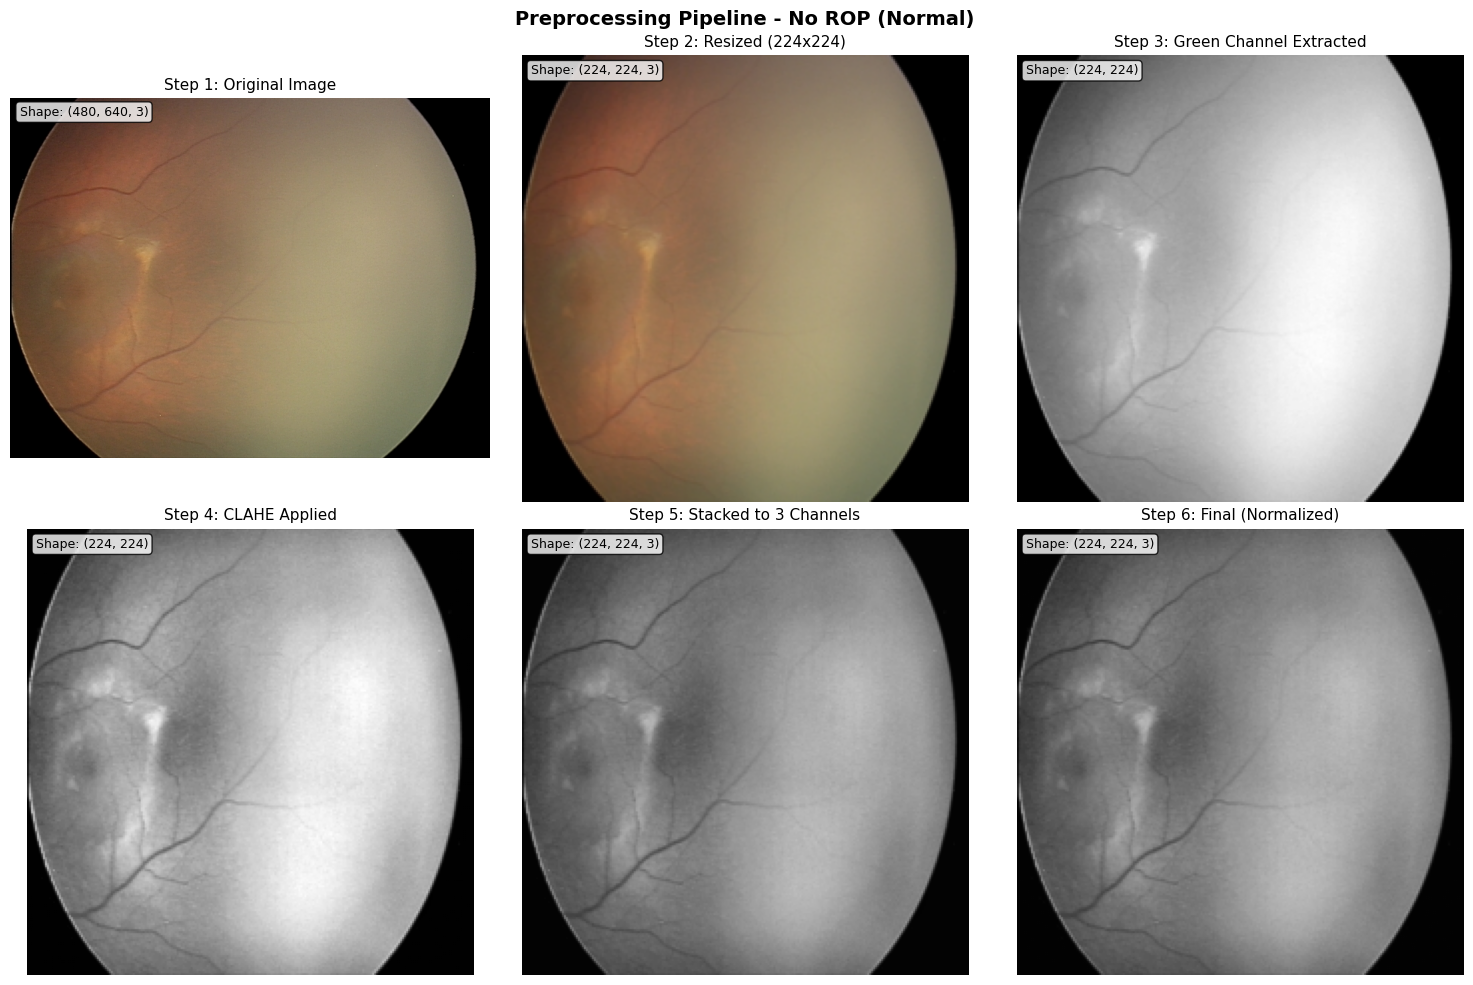

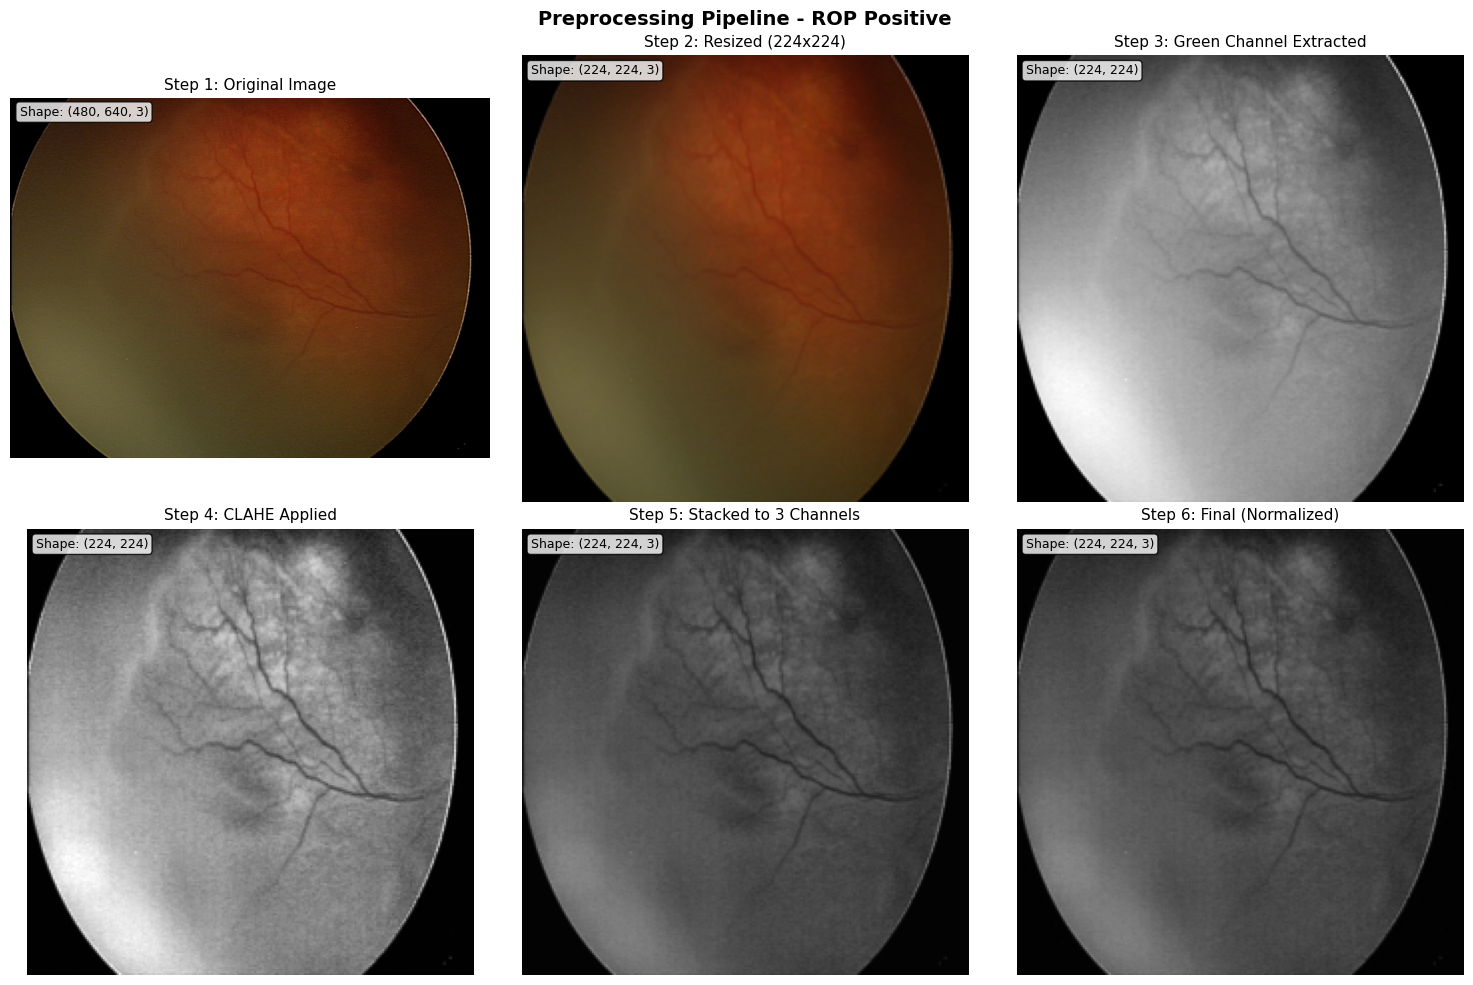

In [5]:
def show_preprocessing_steps(img_path, title):
    """Visualize each preprocessing step for a single image."""
    
    # Step 1: Load original image
    original = Image.open(img_path).convert('RGB')
    original_np = np.array(original)
    
    # Step 2: Resize to 224x224
    resize_transform = transforms.Resize((224, 224))
    resized = resize_transform(original)
    resized_np = np.array(resized)
    
    # Step 3: Extract green channel
    green_channel = resized_np[:, :, 1]
    
    # Step 4: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_applied = clahe.apply(green_channel)
    
    # Step 5: Stack to 3 channels (as done in transforms.py)
    clahe_stacked = np.stack([clahe_applied, clahe_applied, clahe_applied], axis=2)
    
    # Step 6: Apply full transform and denormalize for visualization
    full_transform = get_transforms(train=False)
    tensor_img = full_transform(original)
    
    # Denormalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denorm = (tensor_img * std + mean).clamp(0, 1)
    final_np = denorm.permute(1, 2, 0).numpy()
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Preprocessing Pipeline - {title}', fontsize=14, fontweight='bold')
    
    steps = [
        (original_np, 'Step 1: Original Image', 'RGB'),
        (resized_np, 'Step 2: Resized (224x224)', 'RGB'),
        (green_channel, 'Step 3: Green Channel Extracted', 'gray'),
        (clahe_applied, 'Step 4: CLAHE Applied', 'gray'),
        (clahe_stacked, 'Step 5: Stacked to 3 Channels', 'RGB'),
        (final_np, 'Step 6: Final (Normalized)', 'RGB')
    ]
    
    for ax, (img, step_title, cmap) in zip(axes.flat, steps):
        if cmap == 'gray':
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        ax.set_title(step_title, fontsize=11)
        ax.axis('off')
        
        # Add shape info
        if isinstance(img, np.ndarray):
            ax.text(0.02, 0.98, f'Shape: {img.shape}', transform=ax.transAxes,
                   fontsize=9, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Show preprocessing for both samples
for img_path, label in sample_images:
    fig = show_preprocessing_steps(img_path, label)
    plt.savefig(PROJECT_ROOT / 'analysis' / f'preprocessing_{label.replace(" ", "_").replace("(", "").replace(")", "")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

## 4. CLAHE Effect Analysis

Detailed comparison showing the effect of CLAHE on retinal images.

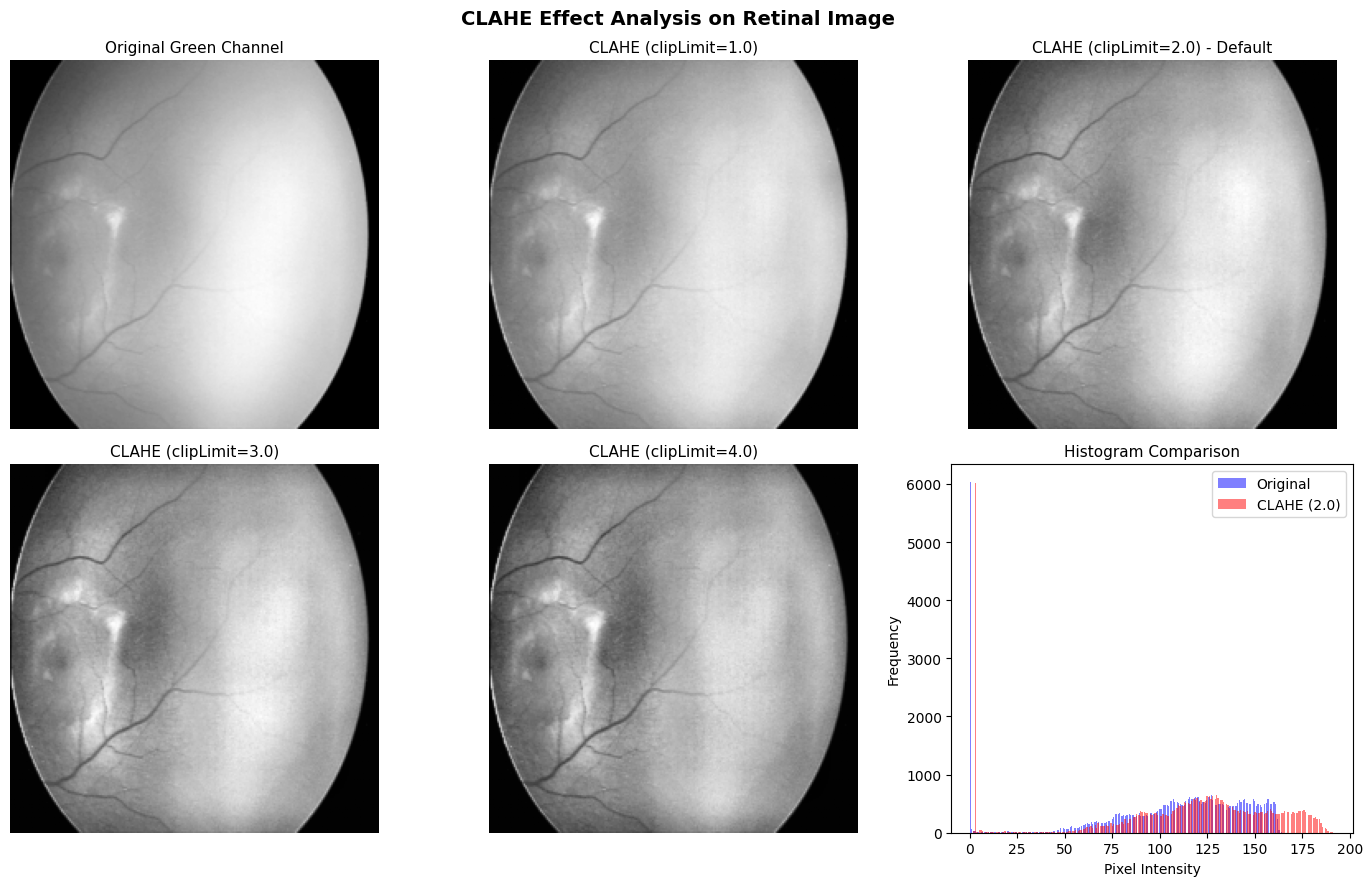

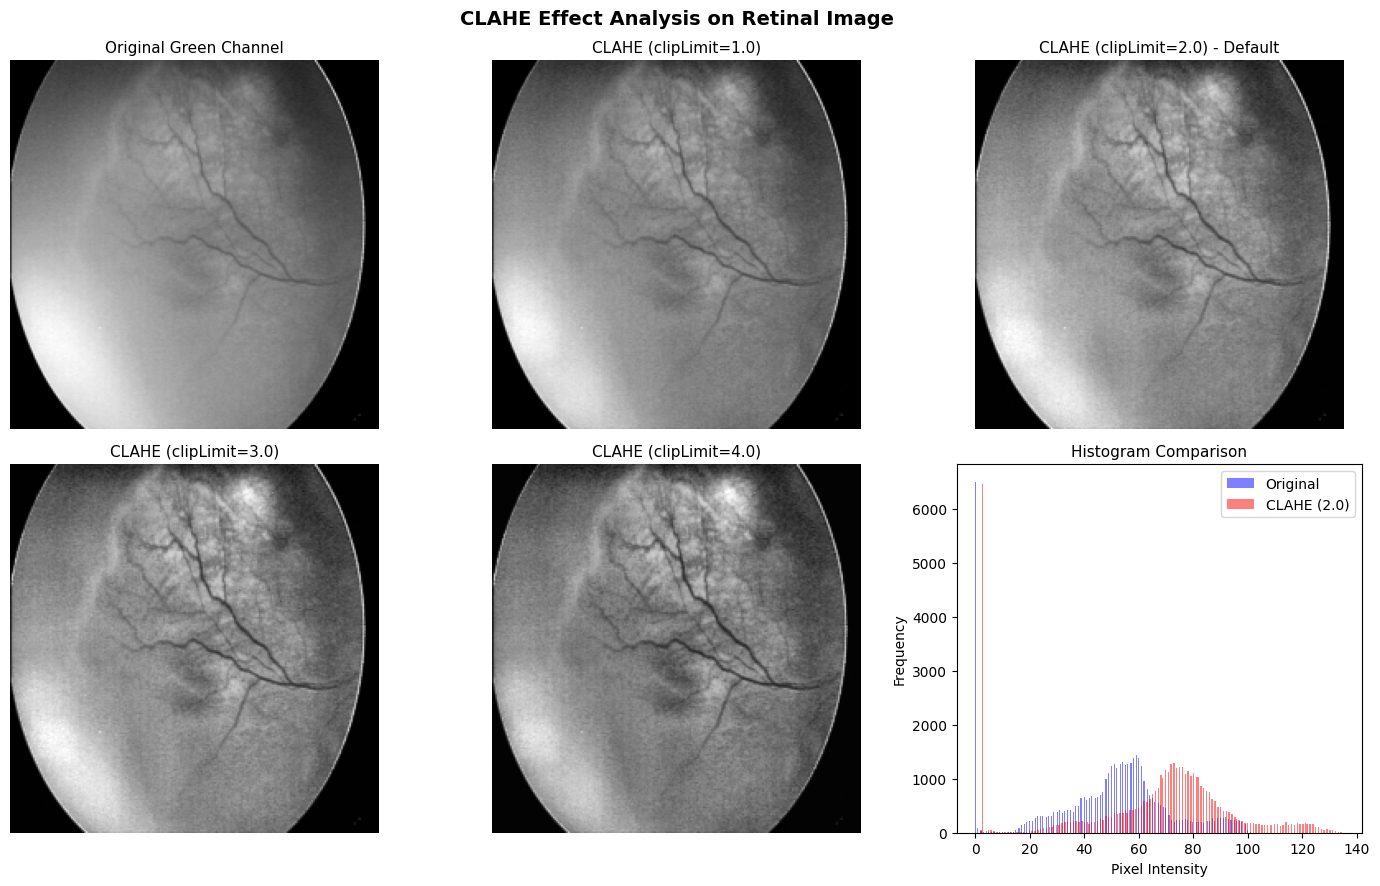

In [6]:
def analyze_clahe_effect(img_path):
    """Analyze the effect of CLAHE with different parameters."""
    
    # Load and resize
    img = Image.open(img_path).convert('RGB')
    img = transforms.Resize((224, 224))(img)
    img_np = np.array(img)
    green = img_np[:, :, 1]
    
    # Different CLAHE configurations
    configs = [
        (None, 'Original Green Channel'),
        (1.0, 'CLAHE (clipLimit=1.0)'),
        (2.0, 'CLAHE (clipLimit=2.0) - Default'),
        (3.0, 'CLAHE (clipLimit=3.0)'),
        (4.0, 'CLAHE (clipLimit=4.0)'),
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.flat
    
    for i, (clip, title) in enumerate(configs):
        if clip is None:
            result = green
        else:
            clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
            result = clahe.apply(green)
        
        axes[i].imshow(result, cmap='gray')
        axes[i].set_title(title, fontsize=11)
        axes[i].axis('off')
    
    # Histogram comparison in last subplot
    axes[5].hist(green.ravel(), bins=256, alpha=0.5, label='Original', color='blue')
    clahe_default = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(green)
    axes[5].hist(clahe_default.ravel(), bins=256, alpha=0.5, label='CLAHE (2.0)', color='red')
    axes[5].set_title('Histogram Comparison', fontsize=11)
    axes[5].legend()
    axes[5].set_xlabel('Pixel Intensity')
    axes[5].set_ylabel('Frequency')
    
    fig.suptitle('CLAHE Effect Analysis on Retinal Image', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

# Analyze CLAHE for both samples
for img_path, label in sample_images:
    fig = analyze_clahe_effect(img_path)
    plt.savefig(PROJECT_ROOT / 'analysis' / f'clahe_analysis_{label.replace(" ", "_").replace("(", "").replace(")", "")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

## 5. Sample Grid Visualization

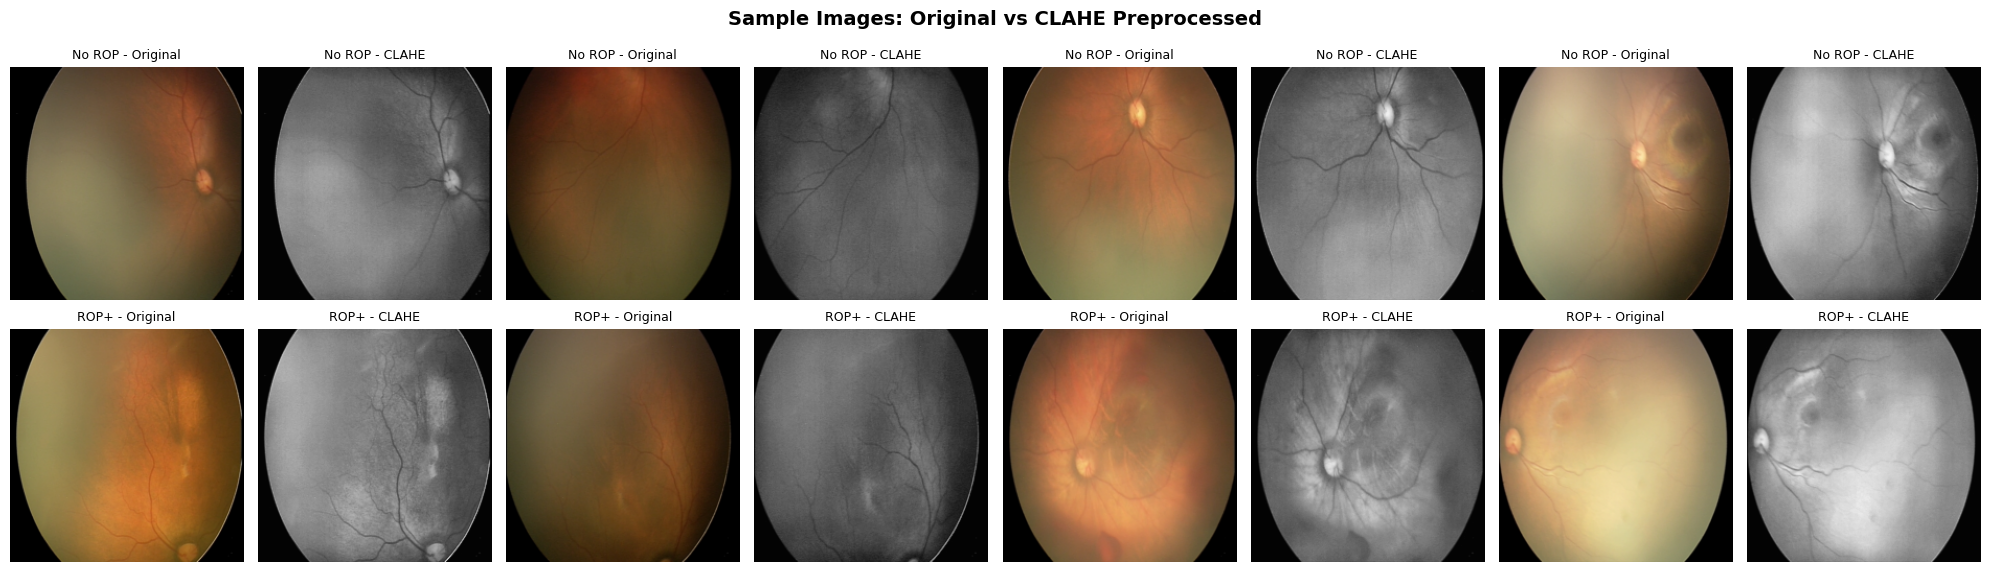

In [7]:
# Create a grid of sample images from both classes
n_samples = 4

rop_positive_samples = train_df[train_df['ROP Label'] == 1].sample(n_samples, random_state=42)['Source'].tolist()
rop_negative_samples = train_df[train_df['ROP Label'] == 0].sample(n_samples, random_state=42)['Source'].tolist()

fig, axes = plt.subplots(2, n_samples * 2, figsize=(20, 6))
fig.suptitle('Sample Images: Original vs CLAHE Preprocessed', fontsize=14, fontweight='bold')

clahe_transform = CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8))
resize_transform = transforms.Resize((224, 224))

# Row 0: ROP Negative
# Row 1: ROP Positive
for row, (samples, label) in enumerate([(rop_negative_samples, 'No ROP'), (rop_positive_samples, 'ROP+')]):
    for i, img_path in enumerate(samples):
        # Original
        img = Image.open(img_path).convert('RGB')
        img_resized = resize_transform(img)
        
        col_orig = i * 2
        col_clahe = i * 2 + 1
        
        axes[row, col_orig].imshow(img_resized)
        axes[row, col_orig].set_title(f'{label} - Original', fontsize=9)
        axes[row, col_orig].axis('off')
        
        # CLAHE
        clahe_img = clahe_transform(img_resized)
        axes[row, col_clahe].imshow(clahe_img)
        axes[row, col_clahe].set_title(f'{label} - CLAHE', fontsize=9)
        axes[row, col_clahe].axis('off')

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'analysis' / 'sample_grid.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Model Architecture Visualization

In [8]:
# Load model
model = ResNet18ROP(pretrained=True)
print("Model Architecture: ResNet18 for ROP Detection")
print("="*60)
print(model)
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Architecture: ResNet18 for ROP Detection
ResNet18ROP(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d

In [9]:
# Test model with a sample input
model.eval()
sample_input = torch.randn(1, 3, 224, 224)

with torch.no_grad():
    output = model(sample_input)
    
print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output (logits): {output.item():.4f}")
print(f"Probability (sigmoid): {torch.sigmoid(output).item():.4f}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1])
Output (logits): -0.4539
Probability (sigmoid): 0.3884


## 7. DataLoader Test

In [10]:
# Test the dataset and dataloader
train_dataset = ROPDataset(train_csv, get_transforms(train=True))
val_dataset = ROPDataset(val_csv, get_transforms(train=False))

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Get a sample
sample_img, sample_label = train_dataset[0]
print(f"\nSample image tensor shape: {sample_img.shape}")
print(f"Sample label: {sample_label.item()} ({'ROP+' if sample_label.item() == 1 else 'No ROP'})")
print(f"Image tensor stats: min={sample_img.min():.3f}, max={sample_img.max():.3f}, mean={sample_img.mean():.3f}")

Training dataset size: 398
Validation dataset size: 86

Sample image tensor shape: torch.Size([3, 224, 224])
Sample label: 0.0 (No ROP)
Image tensor stats: min=-2.084, max=1.559, mean=-0.042


In [11]:
# Create dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get a batch
batch_imgs, batch_labels = next(iter(train_loader))
print(f"Batch images shape: {batch_imgs.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"Labels in batch: {batch_labels.tolist()}")

Batch images shape: torch.Size([16, 3, 224, 224])
Batch labels shape: torch.Size([16])
Labels in batch: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


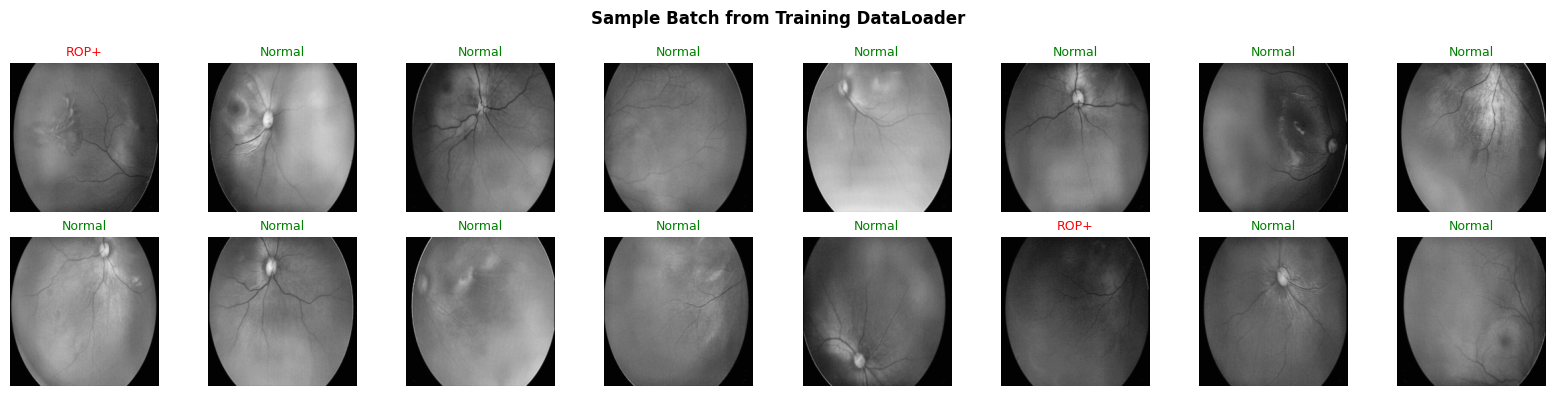

In [12]:
# Visualize a batch
fig, axes = plt.subplots(2, 8, figsize=(16, 4))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i, ax in enumerate(axes.flat):
    img = batch_imgs[i]
    label = batch_labels[i].item()
    
    # Denormalize
    img_denorm = (img * std + mean).clamp(0, 1)
    img_np = img_denorm.permute(1, 2, 0).numpy()
    
    ax.imshow(img_np)
    ax.set_title(f"{'ROP+' if label == 1 else 'Normal'}", 
                 fontsize=9, color='red' if label == 1 else 'green')
    ax.axis('off')

fig.suptitle('Sample Batch from Training DataLoader', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'analysis' / 'batch_sample.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Model Inference Test (with Pre-trained Weights)

In [13]:
# Load the best model checkpoint if available
checkpoint_path = PROJECT_ROOT / "checkpoints" / "best_model.pth"

if checkpoint_path.exists():
    model = ResNet18ROP(pretrained=False).to(DEVICE)
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    model.eval()
    print(f"✅ Loaded checkpoint from: {checkpoint_path}")
    
    # Run inference on validation set
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    all_probs = np.array(all_probs)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    print(f"\nValidation Inference Complete!")
    print(f"Total samples: {len(all_labels)}")
else:
    print(f"⚠️ No checkpoint found at {checkpoint_path}")
    print("Skipping inference test - train the model first!")

c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\ROPDetectionAIML\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\HP\AppData\Local\Temp\ipykernel_29084\511114429.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

✅ Loaded checkpoint from: c:\Users\HP\Desktop\ROPDetectionAIML\checkpoints\best_model.pth

Validation Inference Complete!
Total samples: 86


## 9. Performance Metrics & Plots

In [14]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             roc_curve, precision_recall_curve, classification_report)

if checkpoint_path.exists():
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    
    print("="*50)
    print("VALIDATION SET PERFORMANCE METRICS")
    print("="*50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print("="*50)
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['No ROP', 'ROP+']))
else:
    print("No checkpoint available - skipping metrics calculation")

VALIDATION SET PERFORMANCE METRICS
Accuracy:  0.8488
Precision: 0.7500
Recall:    0.6522
F1-Score:  0.6977
AUC-ROC:   0.9137

Classification Report:
              precision    recall  f1-score   support

      No ROP       0.88      0.92      0.90        63
        ROP+       0.75      0.65      0.70        23

    accuracy                           0.85        86
   macro avg       0.81      0.79      0.80        86
weighted avg       0.84      0.85      0.85        86



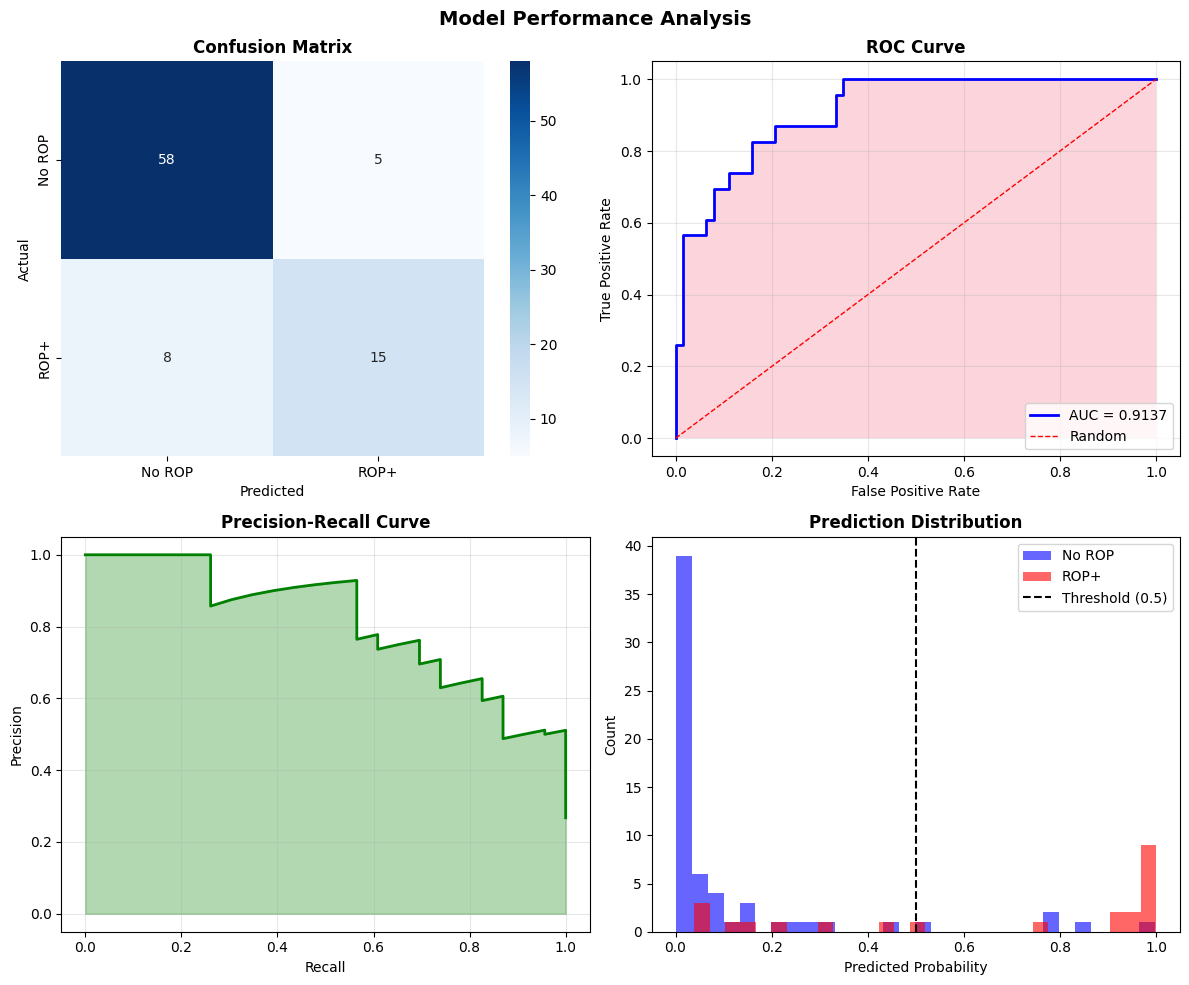

In [15]:
if checkpoint_path.exists():
    # Create comprehensive performance plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['No ROP', 'ROP+'], yticklabels=['No ROP', 'ROP+'])
    axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc:.4f}')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
    axes[0, 1].fill_between(fpr, tpr, alpha=0.3)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve', fontsize=12, fontweight='bold')
    axes[0, 1].legend(loc='lower right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(all_labels, all_probs)
    axes[1, 0].plot(rec, prec, 'g-', linewidth=2)
    axes[1, 0].fill_between(rec, prec, alpha=0.3, color='green')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Prediction Distribution
    axes[1, 1].hist(all_probs[all_labels == 0], bins=30, alpha=0.6, label='No ROP', color='blue')
    axes[1, 1].hist(all_probs[all_labels == 1], bins=30, alpha=0.6, label='ROP+', color='red')
    axes[1, 1].axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Prediction Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    
    fig.suptitle('Model Performance Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'analysis' / 'performance_plots.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No checkpoint available - skipping performance plots")

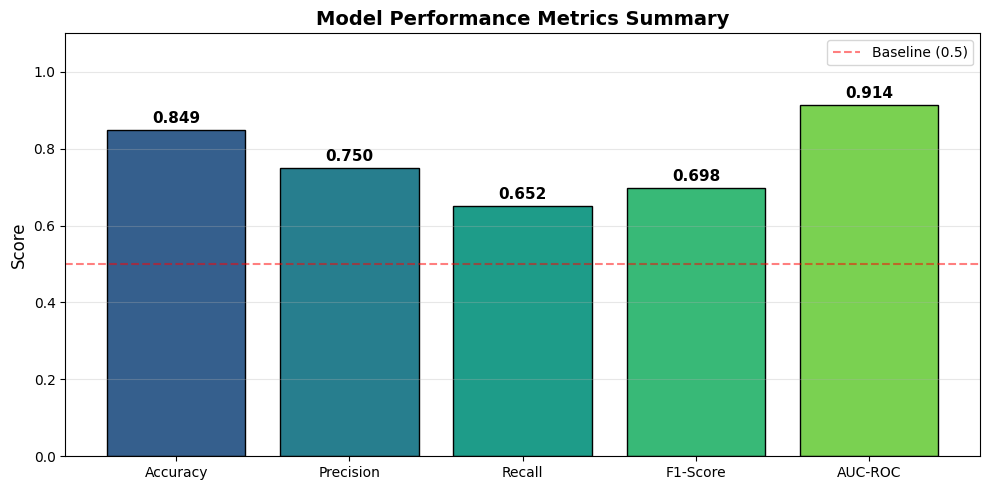

In [16]:
if checkpoint_path.exists():
    # Metrics summary bar chart
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc
    }
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.viridis(np.linspace(0.3, 0.8, len(metrics)))
    bars = ax.bar(metrics.keys(), metrics.values(), color=colors, edgecolor='black')
    
    for bar, val in zip(bars, metrics.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Metrics Summary', fontsize=14, fontweight='bold')
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline (0.5)')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'analysis' / 'metrics_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No checkpoint available - skipping metrics summary")

## 10. Sample Predictions Visualization

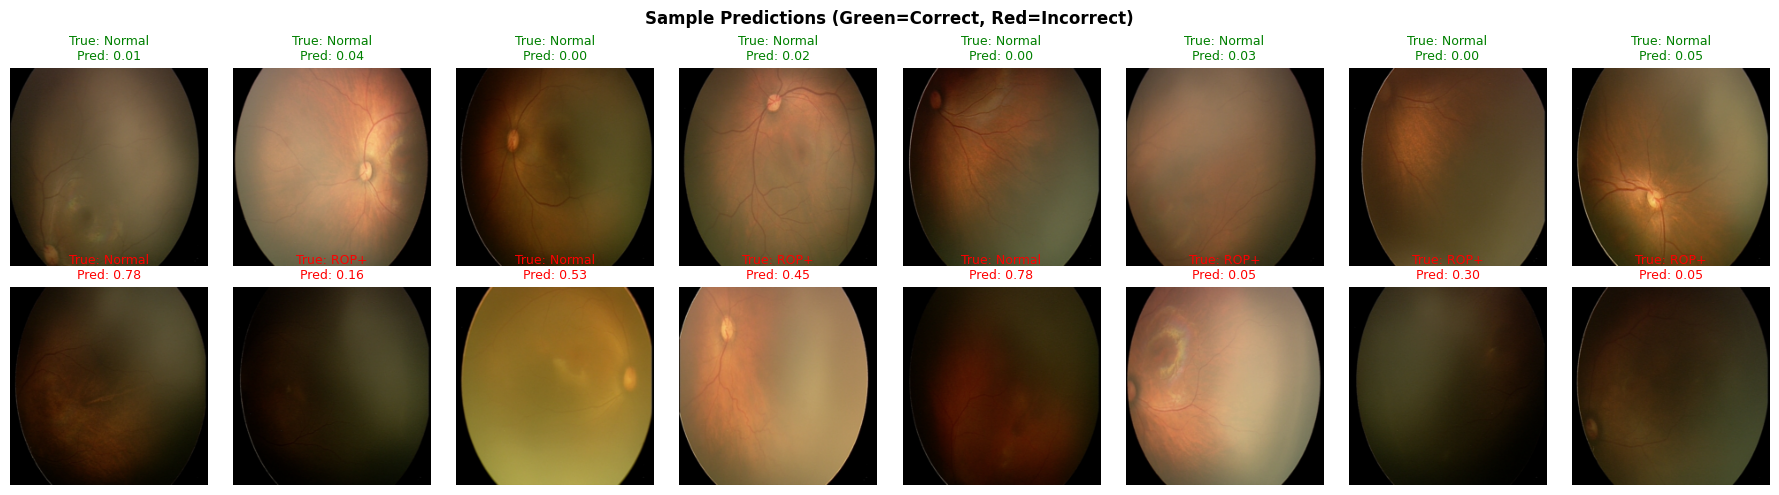

In [17]:
if checkpoint_path.exists():
    # Show some prediction examples
    n_examples = 8
    fig, axes = plt.subplots(2, n_examples, figsize=(18, 5))
    
    # Get sample indices
    correct_idx = np.where(all_preds == all_labels)[0][:n_examples]
    incorrect_idx = np.where(all_preds != all_labels)[0][:n_examples]
    
    val_dataset_no_transform = ROPDataset(val_csv, transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))
    
    # Row 0: Correct predictions
    for i, idx in enumerate(correct_idx[:n_examples]):
        img, label = val_dataset_no_transform[idx]
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[0, i].imshow(img_np)
        axes[0, i].set_title(f'True: {"ROP+" if label else "Normal"}\nPred: {all_probs[idx]:.2f}', 
                            fontsize=9, color='green')
        axes[0, i].axis('off')
    
    axes[0, 0].set_ylabel('Correct\nPredictions', fontsize=10, rotation=0, ha='right', va='center')
    
    # Row 1: Incorrect predictions (if any)
    if len(incorrect_idx) > 0:
        for i, idx in enumerate(incorrect_idx[:n_examples]):
            if i < len(incorrect_idx):
                img, label = val_dataset_no_transform[idx]
                img_np = img.permute(1, 2, 0).numpy()
                
                axes[1, i].imshow(img_np)
                axes[1, i].set_title(f'True: {"ROP+" if label else "Normal"}\nPred: {all_probs[idx]:.2f}', 
                                    fontsize=9, color='red')
                axes[1, i].axis('off')
            else:
                axes[1, i].axis('off')
        axes[1, 0].set_ylabel('Incorrect\nPredictions', fontsize=10, rotation=0, ha='right', va='center')
    else:
        for ax in axes[1]:
            ax.text(0.5, 0.5, 'No incorrect\npredictions!', ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    fig.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'analysis' / 'sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No checkpoint available - skipping sample predictions")

## 11. Pixel Intensity Distribution Analysis

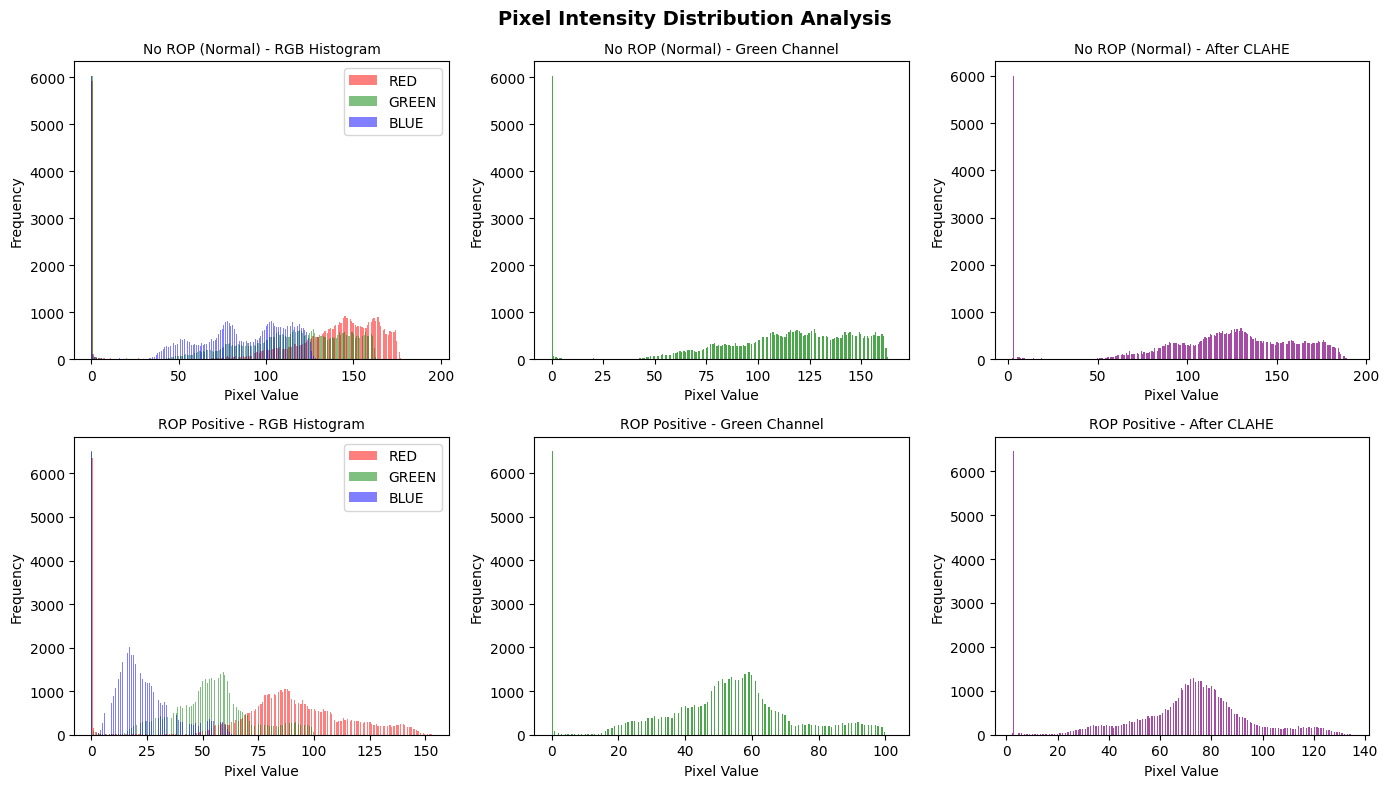

In [18]:
# Analyze pixel distributions before and after preprocessing
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for row, (img_path, label) in enumerate(sample_images):
    # Load image
    img = Image.open(img_path).convert('RGB')
    img_resized = transforms.Resize((224, 224))(img)
    img_np = np.array(img_resized)
    
    # Green channel
    green = img_np[:, :, 1]
    
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(green)
    
    # RGB histogram
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        axes[row, 0].hist(img_np[:, :, i].ravel(), bins=256, alpha=0.5, color=color, label=color.upper())
    axes[row, 0].set_title(f'{label} - RGB Histogram', fontsize=10)
    axes[row, 0].legend()
    axes[row, 0].set_xlabel('Pixel Value')
    axes[row, 0].set_ylabel('Frequency')
    
    # Green channel histogram
    axes[row, 1].hist(green.ravel(), bins=256, color='green', alpha=0.7)
    axes[row, 1].set_title(f'{label} - Green Channel', fontsize=10)
    axes[row, 1].set_xlabel('Pixel Value')
    axes[row, 1].set_ylabel('Frequency')
    
    # CLAHE histogram
    axes[row, 2].hist(clahe_img.ravel(), bins=256, color='purple', alpha=0.7)
    axes[row, 2].set_title(f'{label} - After CLAHE', fontsize=10)
    axes[row, 2].set_xlabel('Pixel Value')
    axes[row, 2].set_ylabel('Frequency')

fig.suptitle('Pixel Intensity Distribution Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'analysis' / 'pixel_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Summary

In [19]:
print("="*60)
print("ROP DETECTION PROJECT TESTING SUMMARY")
print("="*60)

print("\n📊 DATASET SUMMARY:")
print(f"   • Training samples: {len(train_df)}")
print(f"   • Validation samples: {len(val_df)}")
print(f"   • Test samples: {len(test_df)}")
print(f"   • Total: {len(train_df) + len(val_df) + len(test_df)}")

print("\n🔧 PREPROCESSING PIPELINE:")
print("   1. Resize to 224x224")
print("   2. Random Horizontal Flip (training only)")
print("   3. CLAHE on Green Channel (clipLimit=2.0, tileGridSize=8x8)")
print("   4. Convert to Tensor")
print("   5. Normalize (ImageNet mean/std)")

print("\n🧠 MODEL ARCHITECTURE:")
print(f"   • Base: ResNet18 (pretrained on ImageNet)")
print(f"   • Output: Binary classification (sigmoid)")
print(f"   • Total parameters: {total_params:,}")

if checkpoint_path.exists():
    print("\n📈 MODEL PERFORMANCE (Validation Set):")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-Score:  {f1:.4f}")
    print(f"   • AUC-ROC:   {auc:.4f}")
else:
    print("\n⚠️  Model not trained yet - run training first!")

print("\n✅ All tests completed successfully!")
print("="*60)

ROP DETECTION PROJECT TESTING SUMMARY

📊 DATASET SUMMARY:
   • Training samples: 398
   • Validation samples: 86
   • Test samples: 86
   • Total: 570

🔧 PREPROCESSING PIPELINE:
   1. Resize to 224x224
   2. Random Horizontal Flip (training only)
   3. CLAHE on Green Channel (clipLimit=2.0, tileGridSize=8x8)
   4. Convert to Tensor
   5. Normalize (ImageNet mean/std)

🧠 MODEL ARCHITECTURE:
   • Base: ResNet18 (pretrained on ImageNet)
   • Output: Binary classification (sigmoid)
   • Total parameters: 11,177,025

📈 MODEL PERFORMANCE (Validation Set):
   • Accuracy:  0.8488
   • Precision: 0.7500
   • Recall:    0.6522
   • F1-Score:  0.6977
   • AUC-ROC:   0.9137

✅ All tests completed successfully!
